In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
#Loading the dataset
#mnist data set
#from keras.datasets import mnist
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

#CIFAR10 dataset
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
#Splitting the validation data from the training data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.25 , random_state=42)

#preprocessing the data
x_train = x_train.astype('float32') /255
x_valid = x_valid.astype('float32') /255
x_test = x_test.astype('float32') /255

#reshaping the data to take it as an input to the neural network
#mnist
#x_train = x_train.reshape(-1,28*28)
#x_valid = x_valid.reshape(-1,28*28)
#x_test = x_test.reshape(-1,28*28)
#cifar10
x_train = x_train.reshape(-1,32*32*3)
x_valid = x_valid.reshape(-1,32*32*3)
x_test = x_test.reshape(-1,32*32*3)


In [4]:
#Defining custom layer
#template 1
class Dens(keras.layers.Layer):#this class inherits the Layer class from the layers module of keras
    #setting up the constructor
    def __init__(self, a_units, a_input_dim):#a simply is there as i m differentitaing them as arguments
        super(Dens, self).__init__() #this step will run the super class that is the layer class(dont know its significance yet) 
        #defining the weights
        self.w = self.add_weight(name = 'w',shape = (a_input_dim, a_units),initializer = "random_normal",trainable = True)
        #defining the bias(one for each unit)
        self.b = self.add_weight(name = 'b',shape = (a_units,),initializer = 'zeros',trainable = True)
    #defining a method to call this layer that will take inputs and return the wx+b type of thing
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
#template 2
class simpledense(keras.layers.Layer):
    def __init__(self, a_units):
        super(simpledense, self).__init__()
        self.units = a_units
    
    def build(self, input_shape):
        self.w = self.add_weight( name = 'w',
            shape = (input_shape[-1], self.units),initializer = "random_normal",trainable = True)
        self.b = self.add_weight(name = 'b',shape = (self.units,),initializer = "random_normal",trainable = True)
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
#defining a class for relu function
class MyRelu(keras.layers.Layer):
    def __init__(self):
        super(MyRelu, self).__init__()

    def call(self , x):
        return tf.math.maximum(x, 0)

#defining the custom model class
class MyModel(keras.Model):

    #defining and initializing the layers
    def __init__(self,num_classes):#num_classes = 10 for mnist(0-9)
        super(MyModel, self).__init__()
        self.dense1 = Dens(64, 784)
        self.dense2 = Dens(32,64)
    def call(self, input_tensor):
        x = tf.nn.relu(self.dense1(input_tensor))
        return self.dense2(x)

#defining model2
class MyModel2(keras.Model):

    #defining and initializing the layers
    def __init__(self,num_classes):#num_classes = 10 for mnist(0-9)
        super(MyModel2, self).__init__()
        self.dense1 = simpledense(64)
        self.dense2 = simpledense(32)
        self.dense3 = simpledense(16)
        self.output_final = simpledense(num_classes)
        self.relu = MyRelu()
    def call(self, input_tensor):
        x = self.relu(self.dense1(input_tensor))#connects input tensor with the first hidden layer and the applies the relu activation function
        x = self.relu(self.dense2(x)) #connects 1st hidden layer to second layer and performs relu
        x = self.relu(self.dense3(x)) #connects 2nd to 3rd hidden layer and perfomrs relu
        return keras.activations.softmax(self.output_final(x),axis=-1)



In [5]:
#Compiling the model
num_classes = 10
model = MyModel2(num_classes)
model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(),metrics = ["accuracy"]
)
#model.build(input_shape=[32*32*3,1])
#model.summary()


In [6]:
#Evaluating and fitting the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_valid, y_valid ))
#score = model.evaluate(x_test, y_test, verbose = 0) 

#print('Test loss:', score[0]) 
#print('Test accuracy:', score[1])

#model.summary()

Epoch 1/10
1172/1172 [==============================] - 5s 4ms/step - loss: 1.9779 - accuracy: 0.2630 - val_loss: 1.8600 - val_accuracy: 0.3122
Epoch 2/10
1172/1172 [==============================] - 4s 4ms/step - loss: 1.8123 - accuracy: 0.3437 - val_loss: 1.7545 - val_accuracy: 0.3654
Epoch 3/10
1172/1172 [==============================] - 5s 4ms/step - loss: 1.7343 - accuracy: 0.3727 - val_loss: 1.7108 - val_accuracy: 0.3791
Epoch 4/10
1172/1172 [==============================] - 3s 3ms/step - loss: 1.6879 - accuracy: 0.3895 - val_loss: 1.6830 - val_accuracy: 0.3936
Epoch 5/10
1172/1172 [==============================] - 3s 3ms/step - loss: 1.6485 - accuracy: 0.4054 - val_loss: 1.6291 - val_accuracy: 0.4061
Epoch 6/10
1172/1172 [==============================] - 3s 3ms/step - loss: 1.6156 - accuracy: 0.4170 - val_loss: 1.6049 - val_accuracy: 0.4153
Epoch 7/10
1172/1172 [==============================] - 3s 3ms/step - loss: 1.5862 - accuracy: 0.4277 - val_loss: 1.5763 - val_accuracy:

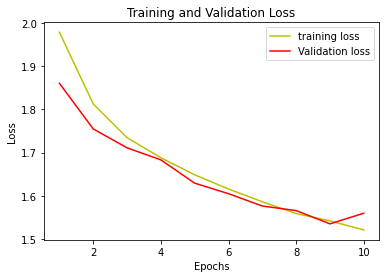

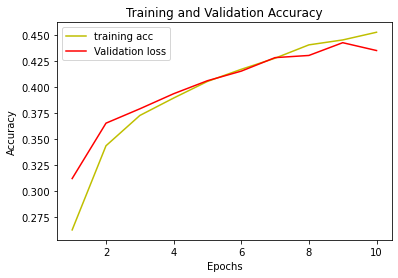

In [7]:
#plotting the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
#predicting the test set results
y_pred = model.predict(x_test)
final_pred = np.zeros(10000)
for i in range(0,y_pred.shape[0]):
    for j in range(0,num_classes):
        if(y_pred[i][j]>=0.5):
           final_pred[i] = j

#Making the confusion Matrix
from sklearn.metrics import  confusion_matrix
cm = confusion_matrix(y_test, final_pred)
print(cm)

313/313 [==============================] - 1s 2ms/step
[[854  20   1   1   5   0   3   7  87  22]
 [438 431   0   1   2   1   5   4  37  81]
 [828   9   7  10  95   6  13  18   6   8]
 [862   6   0  41  20  13  15  10  17  16]
 [715   5   0   0 233   0  11  22   8   6]
 [798   5   0  29  30  82   8  26  19   3]
 [749   4   0  11  71   0 154   3   5   3]
 [588  10   1   4  64   9   3 273   5  43]
 [444  32   0   3   5   1   0   4 483  28]
 [464 127   0   0   1   1   5   9  28 365]]


In [9]:
model.summary()

Model: "my_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simpledense (simpledense)   multiple                  196672    
                                                                 
 simpledense_1 (simpledense)  multiple                 2080      
                                                                 
 simpledense_2 (simpledense)  multiple                 528       
                                                                 
 simpledense_3 (simpledense)  multiple                 170       
                                                                 
 my_relu (MyRelu)            multiple                  0         
                                                                 
Total params: 199,450
Trainable params: 199,450
Non-trainable params: 0
_________________________________________________________________
